In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import mne
from antio import read_cnt
from antio.parser import read_triggers
from matplotlib import pyplot as plt
from mne.datasets import testing
from mne.io import read_raw_brainvision
from mne.io import read_raw_ant
from mne.viz import plot_topomap
import glob
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

import scipy.io as scio


from mne.viz import set_browser_backend
set_browser_backend("qt")

#%matplotlib widget

Using qt as 2D backend.


In [2]:
def get_eeg_files_in_folder(path,target):
    files = os.listdir(path)
    target_files = [file for file in files if file.endswith(target)]
    return target_files
def eeg_path(root_path,sub_index):
    participant_list = os.listdir(root_path)
    cnt_path = glob.glob(root_path+participant_list[sub_index]+'/'+'*.cnt')[0]
    evt_path = glob.glob(root_path+participant_list[sub_index]+'/'+'*.evt')[0]
    trg_path = glob.glob(root_path+participant_list[sub_index]+'/'+'*.trg')[0]
    return cnt_path,evt_path,trg_path

def eeg_path_BV(root_path,sub_index):
    participant_list = os.listdir(root_path)
    eeg_path = glob.glob(root_path+participant_list[sub_index]+'/'+'*.eeg')[0]
    vhdr_path = glob.glob(root_path+participant_list[sub_index]+'/'+'*.vhdr')[0]
    vmrk_path = glob.glob(root_path+participant_list[sub_index]+'/'+'*.vmrk')[0]
    return eeg_path,vhdr_path,vmrk_path

def split_session_events(events,event_id):
    button_index = event_id['16']
    sound_index = event_id['96']
    event_list = np.array(events)
    if '64' in event_id:
        event_list[event_list[:,2]==event_id['64'],2]=event_id['96']
    #print(event_list[:,2],'\n',event_id['96'],event_id)
    locker_identifier_1 = [button_index]*2+[sound_index]*3+[button_index]*2+[sound_index]+[button_index]*2+[sound_index]*3+[button_index]*2
    locker_identifier_2 = [button_index]*2+[sound_index]*3+[button_index]*2+[sound_index]+[sound_index]*3+[button_index]*2
    head_trigger_type = [sound_index]*3+[button_index]
    tail_trigger_type = [sound_index]+[button_index]*2+[sound_index]

    locker_head = []
    locker_tail = []
    for i in range(event_list.shape[0]-25):
        if (list(event_list[i:(i+len(locker_identifier_1)+len(head_trigger_type)),2])==locker_identifier_1+head_trigger_type)| \
            (list(event_list[i:(i+len(locker_identifier_2)+len(head_trigger_type)),2])==locker_identifier_2+head_trigger_type):
            locker_head = locker_head + [i+2]
        elif (list(event_list[i:(i+len(locker_identifier_1)+len(tail_trigger_type)),2])==locker_identifier_1+tail_trigger_type)| \
            (list(event_list[i:(i+len(locker_identifier_2)+len(tail_trigger_type)),2])==locker_identifier_2+tail_trigger_type):
            locker_tail = locker_tail + [i+12]
    #print('Head: ',len(locker_head),'.  Tail: ',len(locker_tail))

    arg_sound = np.where(event_list[:,2]==sound_index)[0]

    sound_trigger_index = np.where(events[:,2]==event_id['96'])[0]
    if len(sound_trigger_index)==540:
        head = sound_trigger_index[60]
    else:
        head = locker_head[0]
    #if len(locker_head)>0:
    #    head = locker_head[0]
    #elif len(locker_head)==0:
    #    head = arg_sound[60]

    if len(locker_tail)>0:
        tail = locker_tail[-1]
    elif len(locker_tail)==0:
        tail = arg_sound[np.where(arg_sound==head)[0][0]+420]-1
    train_event = event_list[(head):(tail+1),:]
    
    #print('Head: ',head,'.  Tail: ',tail)
    #plt.scatter(np.arange(len(event_list[(tail-20):(tail+20),2])),event_list[(tail-20):(tail+20),2])
    #plt.scatter(20,event_list[tail,2],c='r')
    #plt.plot(np.arange(len(event_list[(tail-20):(tail+20),2])),event_list[(tail-20):(tail+20),2])

    #print('Head: ',head,'.  Tail: ',tail)
    #plt.scatter(np.arange(len(event_list[(head-20):(head+20),2])),event_list[(head-20):(head+20),2])
    #plt.scatter(20,event_list[head,2],c='r')
    #plt.plot(np.arange(len(event_list[(head-20):(head+20),2])),event_list[(head-20):(head+20),2])
    
    train_sound_event = train_event[train_event[:,2]==sound_index,:]
    
    if train_sound_event.shape[0]!=420:
        raise ValueError("\nIncorrect training session trial number!!!\n")
    else:
        pre_event = event_list[:(head-1),:]
        post_event = event_list[(tail+1):,:]
        pre_sound_event = pre_event[pre_event[:,2]==sound_index,:]
        if pre_sound_event.shape[0]>60:
            pre_sound_event = pre_sound_event[-61:-1,:]
        post_sound_event = post_event[post_event[:,2]==sound_index,:]
        print('Train_sound_event shape: ',train_sound_event.shape,
              ';   Pre_sound_event shape: ',pre_sound_event.shape,
              ';   Post_sound_event shape: ',post_sound_event.shape)
        return train_sound_event,pre_sound_event,post_sound_event

    #return train_sound_event,head,tail

In [3]:
def load_catch_index_for_TRF(file_path):
    file = scio.loadmat(file_path)
    stim_index = file['participant_log']['stim_index'][0][0]
    pre_index = stim_index[stim_index[:,4]==1,3]
    train_index = stim_index[stim_index[:,4]==2,3]
    post_index = stim_index[stim_index[:,4]==3,3]
    pre_post_NS_index = np.zeros(stim_index.shape[0])
    NS_locker = np.where(stim_index[:,1]==1)[0]
    feature_index = []
    for loc in NS_locker:
        pre_post_NS_index[(loc-3):loc] = 1
        pre_post_NS_index[(loc+1):(loc+4)] = 2
        feature_index = feature_index + list(stim_index[(loc-3):loc,0].astype('int16')-1)
        feature_index = feature_index + [int(stim_index[loc,0]-1)]
        feature_index = feature_index + list(stim_index[(loc+1):(loc+4),0].astype('int16')-1)
        
    pre_post_NS_index = pre_post_NS_index[60:60+420]
    
    return pre_index,train_index,post_index,pre_post_NS_index,np.array(feature_index)

### Stop here to check the participant's ID

In [14]:
if_onset_shifting = True
participant_index = 0

raw_eeg_path = 'C:/Users/yu028288/OneDrive - University of Central Florida/Documents/Python Scripts/SWS_OneShotLearning_2025/Analysis/EEG_SWS/EEG/EEG_SWS/'
#raw_eeg_path = 'C:/Users/yu028288/OneDrive - University of Central Florida/Documents/Python Scripts/SWS_OneShotLearning_2025/Analysis/EEG_SWS/EEG/EEG_SWS_BrainVision/'
participant_list = os.listdir(raw_eeg_path)
print(participant_list)
eeg_file_list = os.listdir(raw_eeg_path+participant_list[participant_index]+'/')
#eeg_file_list = glob.glob(raw_eeg_path+participant_list[0]+'/'+'*.cnt')
print(eeg_file_list)

['Sub-001_June-09', 'Sub-002_June-09', 'Sub-003_June-13', 'Sub-004_June-17', 'Sub-005_June-17', 'Sub-006_June-20', 'Sub-007_June-23', 'Sub-008_June-24', 'Sub-009_June-25', 'Sub-010_July-01', 'Sub-011_July-02', 'Sub-012_July-09', 'Sub-013_July-17', 'Sub-014_July-21', 'Sub-015_July-21', 'Sub-016_July-22', 'Sub-017_July-28', 'Sub-018_July-28', 'Sub-019_July-30']
['Garrett_Burchfield_2025-06-09_13-21-30.cnt', 'Garrett_Burchfield_2025-06-09_13-21-30.evt', 'Garrett_Burchfield_2025-06-09_13-21-30.trg', 'Sub-001_June-09_blk-1_highband_-epo.fif', 'Sub-001_June-09_blk-1_lowband_-epo.fif', 'Sub-001_June-09_blk-2_highband_-epo.fif', 'Sub-001_June-09_blk-2_lowband_-epo.fif', 'Sub-001_June-09_blk-3_highband_-epo.fif', 'Sub-001_June-09_blk-3_lowband_-epo.fif']


In [15]:
####################################################
#Try .cnt format
fname,_,_ = eeg_path(raw_eeg_path,participant_index)
#Load impedances
cnt = read_cnt(fname)
_, _, _, impedances, _ = read_triggers(cnt)
#Load Raw Data
raw = read_raw_ant(fname, eog=r"EOG",preload=False)
raw_event = raw.copy()
#set standard 10-20 Montage
#raw_set_montage = raw.copy()
#raw_set_montage.pick("eeg").set_montage("standard_1020")
raw.pick("eeg").set_montage("standard_1020")
#raw.drop_channels(['M1','M2'])


####################################################
#Try .eeg format
#_,fname,_ = eeg_path_BV(raw_eeg_path,0)
#raw = read_raw_brainvision(fname)
#raw.set_channel_types({'EOG': 'eog'})


Reading ANT file C:/Users/yu028288/OneDrive - University of Central Florida/Documents/Python Scripts/SWS_OneShotLearning_2025/Analysis/EEG_SWS/EEG/EEG_SWS/Sub-001_June-09\Garrett_Burchfield_2025-06-09_13-21-30.cnt
All 63 EEG channels are referenced to CPz.


<RawANT | Garrett_Burchfield_2025-06-09_13-21-30.cnt, 63 x 2069108 (2069.1 s), ~76 KiB, data not loaded>

In [16]:
raw.load_data()
raw_event.load_data()

#raw = mne.add_reference_channels(raw, ref_channels=["CPz"])
#raw_event = mne.add_reference_channels(raw_event, ref_channels=["CPz"])

#raw.pick("eeg").set_montage("standard_1020")

Reading 0 ... 2069107  =      0.000 ...  2069.107 secs...
Reading 0 ... 2069107  =      0.000 ...  2069.107 secs...


<RawANT | Garrett_Burchfield_2025-06-09_13-21-30.cnt, 64 x 2069108 (2069.1 s), ~1010.4 MiB, data loaded>

In [17]:
#raw.del_proj()
#sphere = mne.make_sphere_model("auto", "auto", raw.info)
#src = mne.setup_volume_source_space(sphere=sphere, exclude=30.0, pos=5.0)
#forward = mne.make_forward_solution(raw.info, trans=None, src=src, bem=sphere)
#raw_rer = raw.copy().set_eeg_reference("REST", forward=forward)

In [18]:
print(raw.info)
print(raw.info['ch_names'])

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 63 EEG
 custom_ref_applied: False
 device_info: 4 items (dict)
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2025-06-09 13:21:30 UTC
 nchan: 63
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: , first_name: Burchfield Garrett, sex: 0, birthday: 2003-05-16>
>
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']


In [19]:
#raw.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=10e-5)

In [20]:
#raw.info["bads"] = ['T7','T8']

#print(raw.info)
#print(raw.info.ch_names)
#print(raw_event.info)
#print(raw.info["bads"])

In [21]:
#raw.interpolate_bads(reset_bads=True)

In [22]:
events,event_id = mne.events_from_annotations(raw)
print(events[:5])
print(events[-5:])
print(len(events))
print(event_id)
print(np.where(events[:,2]==event_id['96'])[0].shape)
#train_sound_event,head,tail = split_session_events(events,event_id)
train_sound_event,pre_event,post_event = split_session_events(events,event_id)

Used Annotations descriptions: ['16', '32', '64', '96', 'impedance']
[[    0     0     5]
 [49376     0     1]
 [79516     0     1]
 [84369     0     1]
 [88947     0     1]]
[[1882715       0       1]
 [1884269       0       1]
 [1889553       0       1]
 [1892087       0       1]
 [2069104       0       5]]
1107
{'16': 1, '32': 2, '64': 3, '96': 4, 'impedance': 5}
(538,)
Train_sound_event shape:  (420, 3) ;   Pre_sound_event shape:  (60, 3) ;   Post_sound_event shape:  (60, 3)


## Add onset shifting

In [23]:
participant_log_path = 'C:/Users/yu028288/OneDrive - University of Central Florida/Documents/Python Scripts/SWS_OneShotLearning_2025/Experiment/EEG_Experiment/Final_EEG_Behaviour_Result'
log_file_list = sorted(os.listdir(participant_log_path))
_,train_index,_,pre_post_NS_index,feature_index = load_catch_index_for_TRF(participant_log_path+'/'+log_file_list[participant_index])

word_onset_shifting_list = np.loadtxt('word_onset_shifting_list.txt');

#choose True to run onset shifting
if_onset_shifting = True

if if_onset_shifting&(train_sound_event.shape[0]==420):
    word_onset_sample_shifting_list = word_onset_shifting_list[feature_index]*raw.info['sfreq']
    train_sound_event[:,0] = train_sound_event[:,0] + word_onset_sample_shifting_list.astype('int64')

print(train_sound_event[:,:])

[[ 269507       0       4]
 [ 271219       0       4]
 [ 273192       0       4]
 ...
 [1581784       0       4]
 [1583300       0       4]
 [1585174       0       4]]


### Stop here to check if we have 420 trials

In [24]:
sound_trigger_index = np.where(events[:,2]==event_id['96'])[0]

In [25]:
#Crop
crop_tmin = events[sound_trigger_index[0]][0]/1000-0.3
crop_tmax = events[sound_trigger_index[-1]][0]/1000+1.3

print(crop_tmin,'\n',crop_tmax)

raw = raw.crop(tmin=crop_tmin,tmax=crop_tmax)
raw_event = raw_event.crop(tmin=crop_tmin,tmax=crop_tmax)

89.51 
 1871.9959999999999


In [26]:
raw.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=10e-5)

Channels marked as bad:
none


### Stop here to verify the raw data

In [27]:
#fig,axis = plt.subplots(1,1,figsize = [100,1])
#axis.plot(events[head:(tail+1),2])
#axis.scatter(np.arange(len(events[head:(tail+1),2])),events[head:(tail+1),2])

In [28]:
#events_array = np.array(events[head:(tail+1)])
#i_64 = np.where(events_array[:,2]==3)[0][0]
#i_32 = np.where(events_array[:,2]==2)[0][0]
#print(i_64,i_32,events_array[i_64,0],events_array[i_32,0])
#plt.scatter(events_array[(i_64-10):(i_64+10),0],events_array[(i_64-10):(i_64+10),2])

In [29]:
print(raw.info.ch_names)
#raw.plot(duration=60, n_channels=63, remove_dc=False,color='darkblue',scalings=20e-5)

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\yu028288\AppData\Local\anaconda3\envs\MNE\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


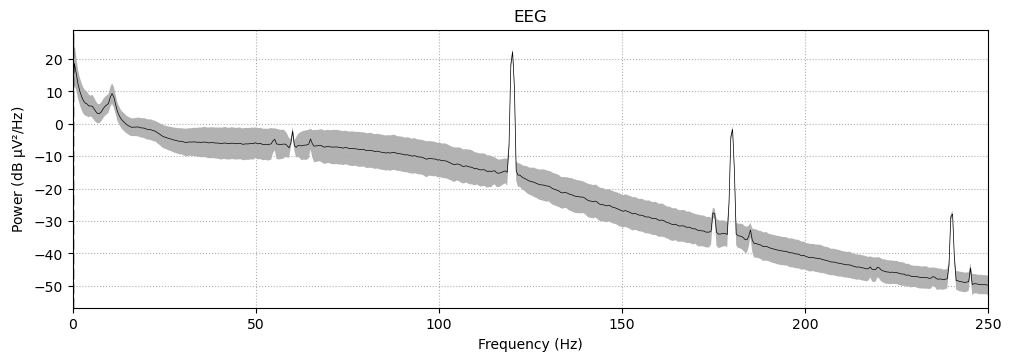

In [30]:
fig = raw.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

In [31]:
print(raw.get_montage())

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 63 channels>


In [32]:
#Test best band
#for cutoff in (30, 40):
#    raw_lowpass = raw.copy().filter(h_freq=cutoff, l_freq=None,n_jobs=8)
#    raw_lowpass = raw_lowpass.filter(h_freq=None, l_freq=0.3,n_jobs=8)
#    with mne.viz.use_browser_backend("matplotlib"):
#        fig = raw_lowpass.plot(duration=60, n_channels=63, remove_dc=False,color='darkblue',scalings=20e-5)
#    fig.subplots_adjust(top=0.9)
#    fig.suptitle(f"High-pass filtered at {cutoff} Hz", size="xx-large", weight="bold")

# Run ICA

In [33]:
def ica_include_exclude(or_list,in_list,ex_list):
    for i in ex_list:
        if i not in or_list:
            or_list = or_list + [i]
    for i in in_list:
        if i in or_list:
            or_list.remove(i)
    
    return or_list

def ica_keep_comp(n_ic,keep_list):
    ic_list = list(np.arange(n_ic))
    for i in ic_list:
        if i in keep_list:
            ic_list.remove(i)
    return ic_list

def raw_subtract(raw1,raw2):
    ch_num = raw1[:,:][0].shape[0]
    raw_out = raw1.copy()
    for i in range(ch_num):
        raw_out[i,:][0][0] = raw1[i,:][0][0] - raw2[i,:][0][0]
    return raw_out

In [34]:
#Fix baseline and pre-filter
raw_remove_baseline = raw.copy()
raw_remove_baseline = raw_remove_baseline.filter(h_freq=None, l_freq=0.1,n_jobs=8)
raw_remove_baseline = raw_remove_baseline.filter(h_freq=45, l_freq=None,n_jobs=8)
raw_eeg_band = raw_remove_baseline.copy().filter(h_freq=15, l_freq=None,n_jobs=8)
raw_eog_band = raw_remove_baseline.copy().filter(h_freq=None, l_freq=1,n_jobs=8)
raw_eog_band = raw_eog_band.filter(h_freq=10, l_freq=None,n_jobs=8)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:   20.8s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 295 samples (0.295 s)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    7.3s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 881 samples (0.881 s)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    7.0s finished


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    7.1s finished


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1321 samples (1.321 s)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    7.0s finished


Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected: 3
Not setting metadata
3 matching events found
No baseline correction applied
Using data from preloaded Raw for 3 events and 1001 original time points ...
0 bad epochs dropped
Applying baseline correction

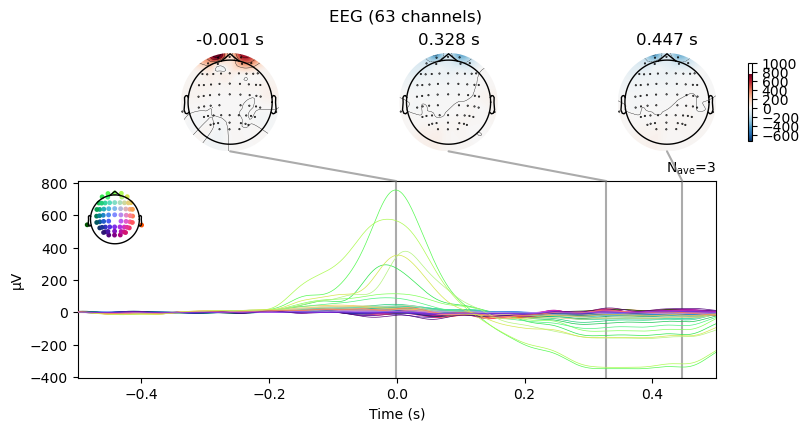

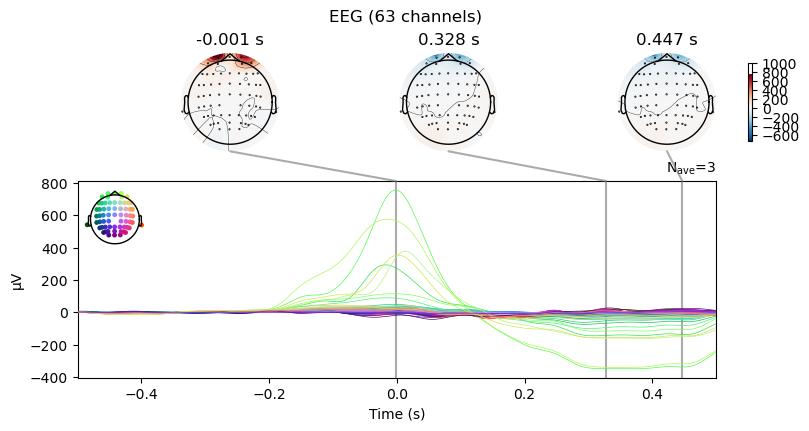

In [35]:
#Acquire EOG
eog_evoked = create_eog_epochs(raw_eeg_band,ch_name=['Fp1','Fp2']).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using channel P8 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 2887 (average pulse 97.17882935471619 / min.)
Not setting metadata
2887 matching events found
No baseline correction applied
Using data from preloaded Raw for 2887 events and 1001 original time points ...
1 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


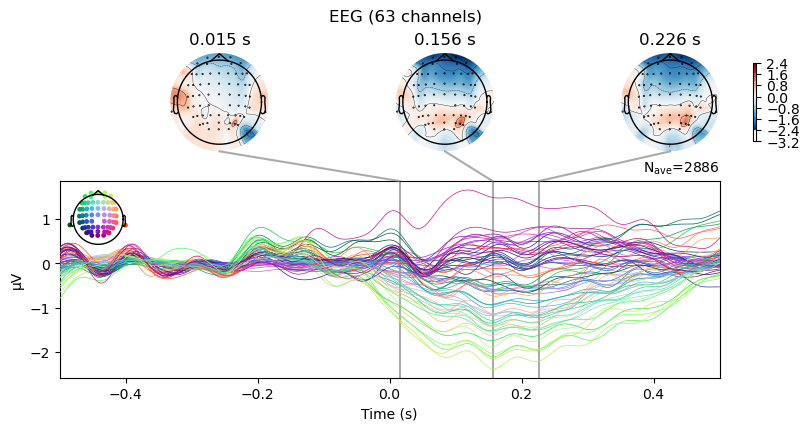

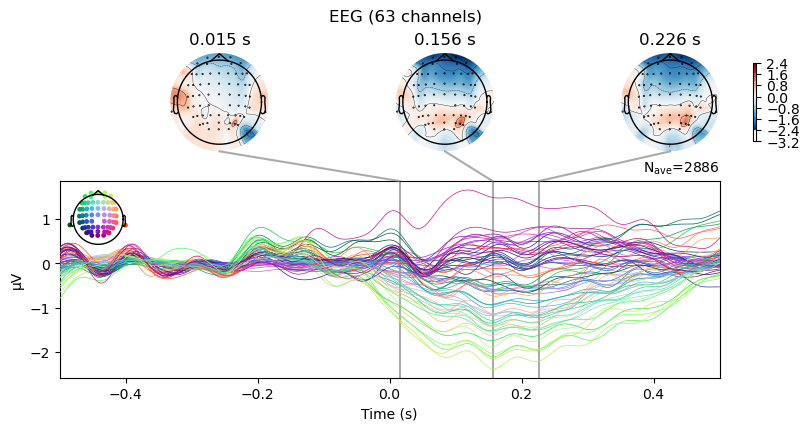

In [36]:
ecg_evoked = create_ecg_epochs(raw_eeg_band,ch_name='P8').average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

In [37]:
#Start ICA in eog band
ica = ICA(n_components=45, max_iter="auto", random_state=97)
ica.fit(raw_eog_band)
ica

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 45 components
Fitting ICA took 252.1s.


<ICA | raw data decomposition, method: fastica (fit in 60 iterations on 1782487 samples), 45 ICA components (63 PCA components available), channel types: eeg, no sources marked for exclusion>

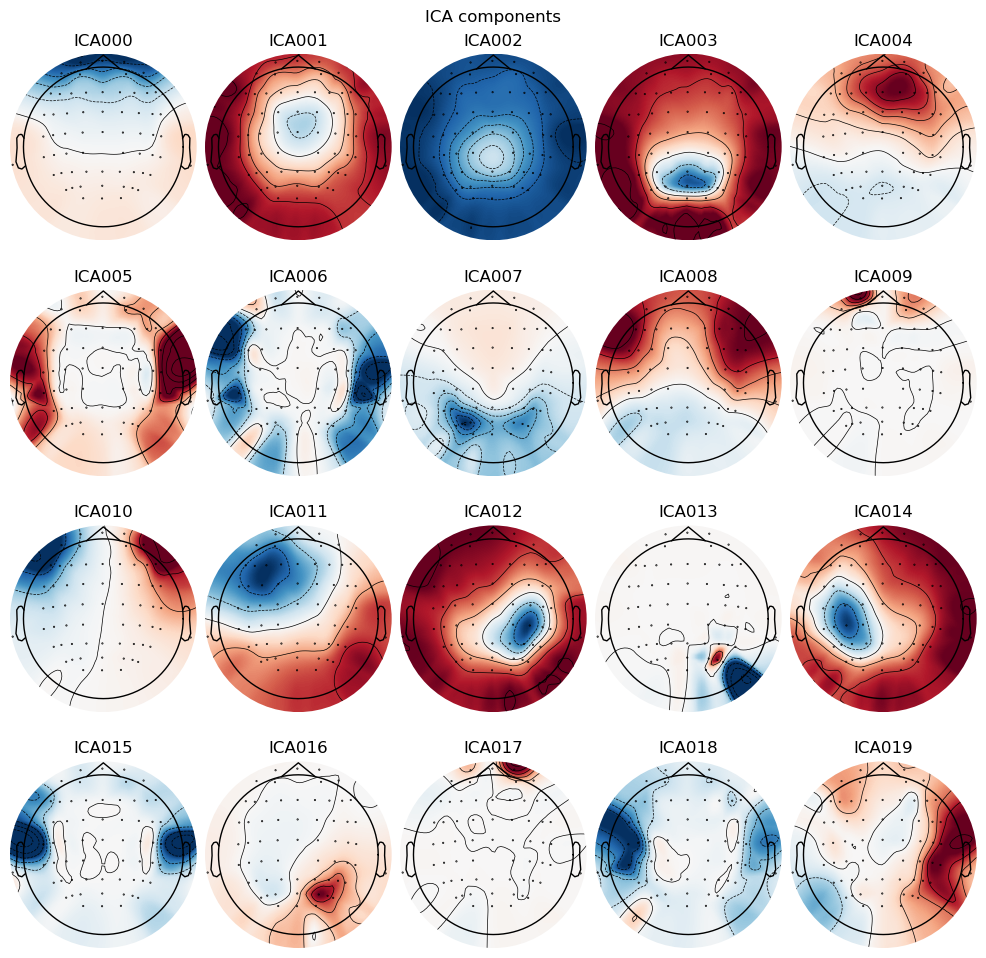

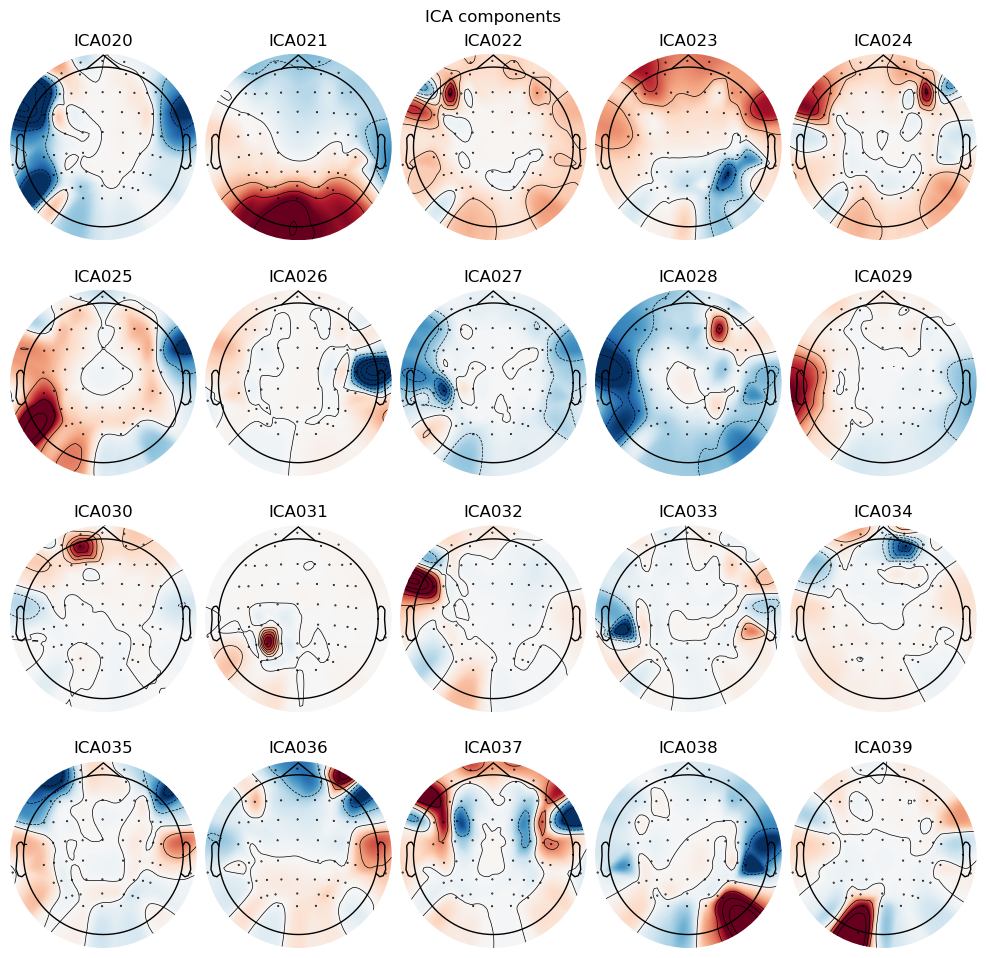

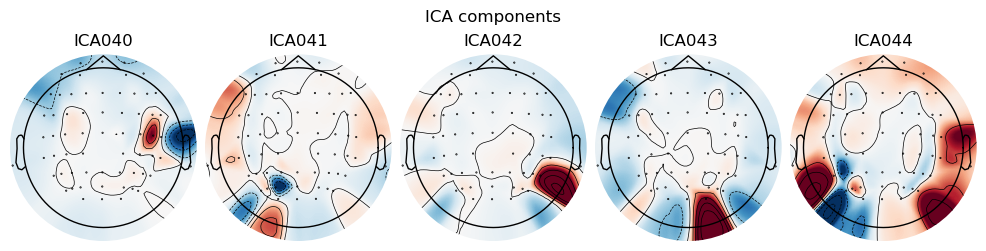

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x260.5 with 5 Axes>]

In [38]:
ica.plot_components()

Using EOG channels: Fp1, AF7, Fp2, AF8, Fpz
... filtering ICA sources
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.0s


... filtering target
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 100

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.2s


... filtering target
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 100

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.4s


... filtering target
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 100

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.7s


... filtering target
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 100

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.8s


... filtering target
Setting up band-pass filter from 0.5 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)



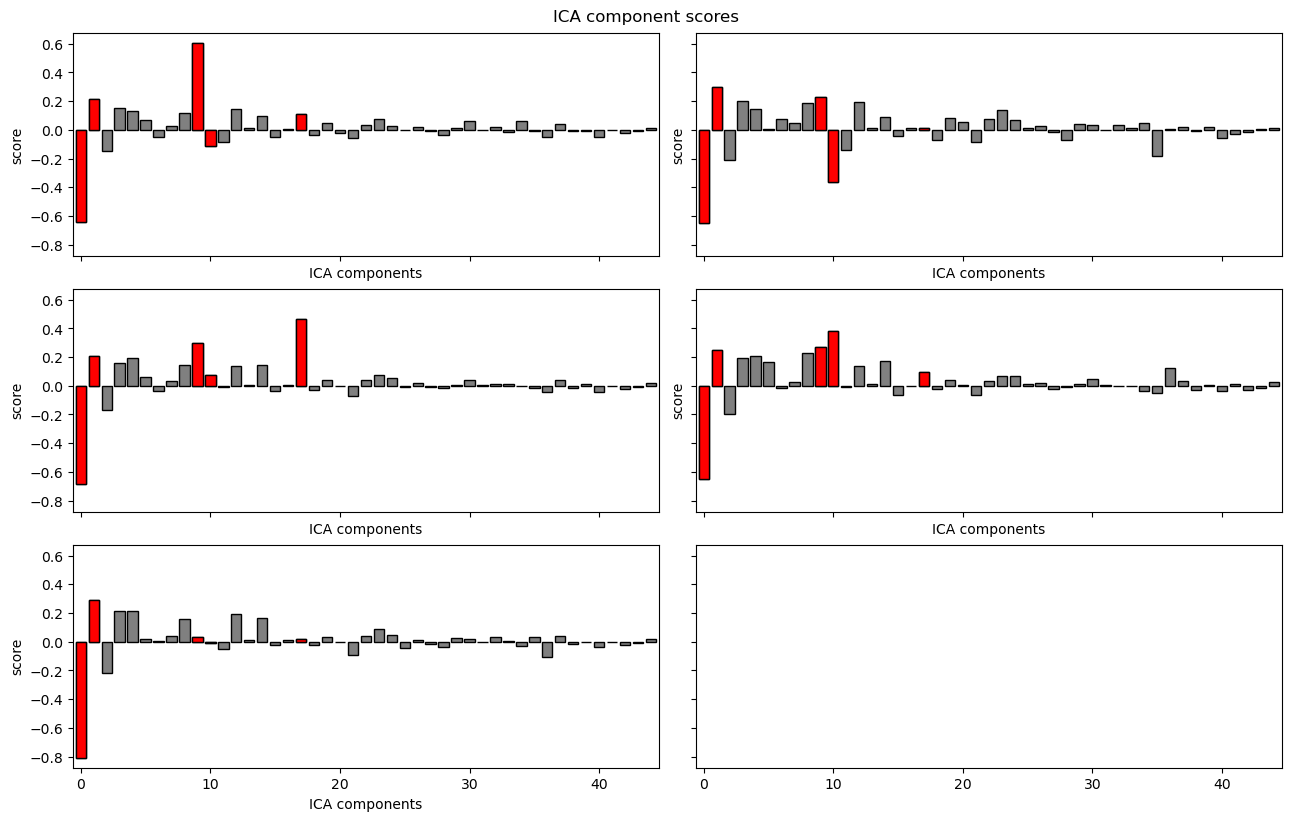

[0, 9, 17, 10, 1]


In [39]:
eog_indices, eog_scores = ica.find_bads_eog(raw_eog_band,ch_name=['Fp1','AF7','Fp2','AF8','Fpz'],l_freq=0.5, h_freq=10)
ica.plot_scores(eog_scores,exclude=eog_indices)
print(eog_indices)

In [40]:

ecg_indices = []
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='T7',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='F7',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='FT7',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='TP7',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='P7',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='T8',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='F8',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='FT8',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='TP8',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='P8',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='PO7',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='PO8',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
ecg_i, ecg_scores = ica.find_bads_ecg(raw_eog_band, ch_name='Oz',method="correlation", threshold="auto")
ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='O1',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_i, ecg_scores = ica.find_bads_ecg(raw_eeg_band, ch_name='O2',method="correlation", threshold="auto")
#ecg_indices = ecg_indices + ecg_i
#ecg_indices = list(set(ecg_indices))


... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)



In [41]:
emg_indices, emg_scores = ica.find_bads_muscle(raw_eog_band,threshold=0.65)

Effective window size : 2.048 (s)


In [42]:
#ica.plot_properties(raw_eeg_band, picks=emg_indices, log_scale=True)

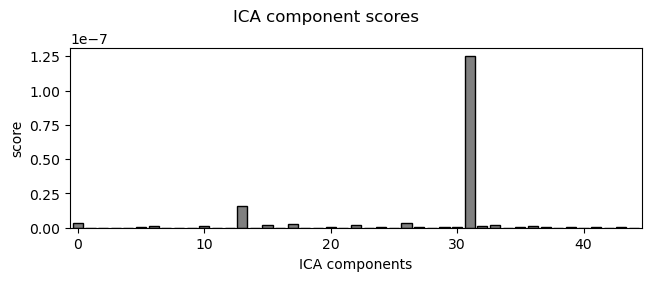

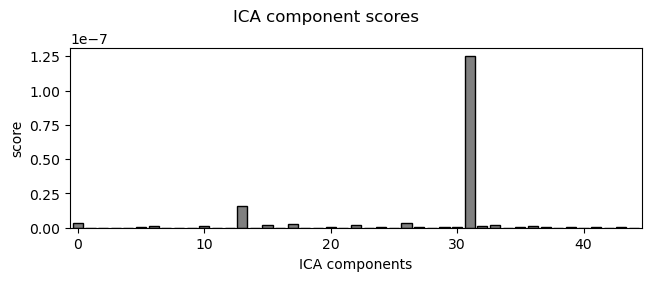

In [43]:
ica.plot_scores(emg_scores, exclude=emg_indices)

In [44]:
print(eog_indices,ecg_indices,emg_indices)
ica_exclude = eog_indices+ecg_indices+emg_indices
print(ica_exclude,len(ica_exclude))

[0, 9, 17, 10, 1] [7, 2, 1] []
[0, 9, 17, 10, 1, 7, 2, 1] 8


In [45]:
ica_exclude_list = ica_exclude
#ica_exclude_list = np.sort(np.unique(np.array(ica_include_exclude(ica_exclude,[],[44]))))
print(ica_exclude_list,len(ica_exclude_list))

[0, 9, 17, 10, 1, 7, 2, 1] 8


8
Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 7 ICA components
    Projecting back using 63 PCA components


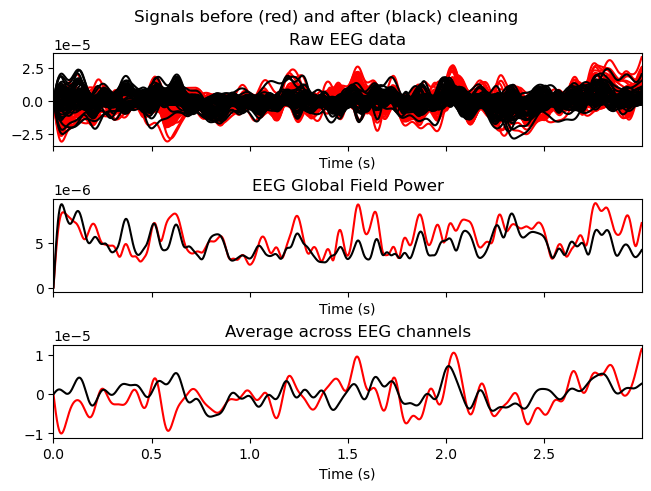

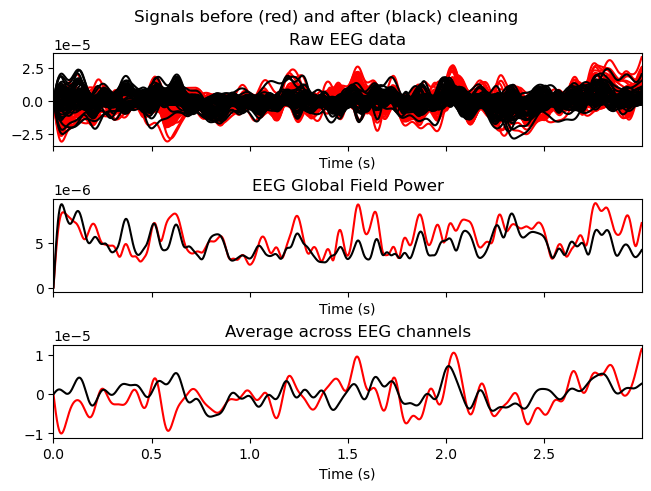

In [46]:
#ICA denoising result
ica.exclude = list(ica_exclude_list)
#ica.exclude = ica_exclude_list
#ica.exclude = ica_exclude_list + [2]
#ica.exclude = ica_keep_comp(45,eog_indices + [2])
#ica.exclude = eog_indices
print(len(ica.exclude))
ica.plot_overlay(raw_eog_band, exclude=ica.exclude, picks="eeg")

In [47]:
ica.plot_sources(raw_eog_band,show_scrollbars=True,splash=False)

Creating RawArray with float64 data, n_channels=45, n_times=1782487
    Range : 89510 ... 1871996 =     89.510 ...  1871.996 secs
Ready.


In [48]:
reconst_eog = raw_eog_band.copy()

In [49]:
ica.apply(reconst_eog)
raw_eeg_band.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=50e-6)
reconst_eog.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=50e-6)

Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 7 ICA components
    Projecting back using 63 PCA components


In [50]:
raw_eeg_eogremove = raw_eeg_band.copy()
ica.apply(raw_eeg_eogremove)
#raw_eeg_eogremove = raw_subtract(raw_eeg_band,reconst_eog)
raw_eeg_eogremove.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=50e-6)

Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 7 ICA components
    Projecting back using 63 PCA components


### Stop here for ICA quality checking

In [52]:
reconst_raw = raw_eeg_eogremove

In [53]:
raw_high_eogremove = raw_remove_baseline.copy()
ica.apply(raw_high_eogremove)

Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 7 ICA components
    Projecting back using 63 PCA components


<RawANT | Garrett_Burchfield_2025-06-09_13-21-30.cnt, 63 x 1782487 (1782.5 s), ~856.8 MiB, data loaded>

In [54]:
if_detrend = 1

# Low Band

### ICA

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 45 components
Fitting ICA took 234.9s.
... filtering ICA sources
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.5s


... filtering target
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)


 [] 
 

0
Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 0 ICA components
    Projecting back using 63 PCA components


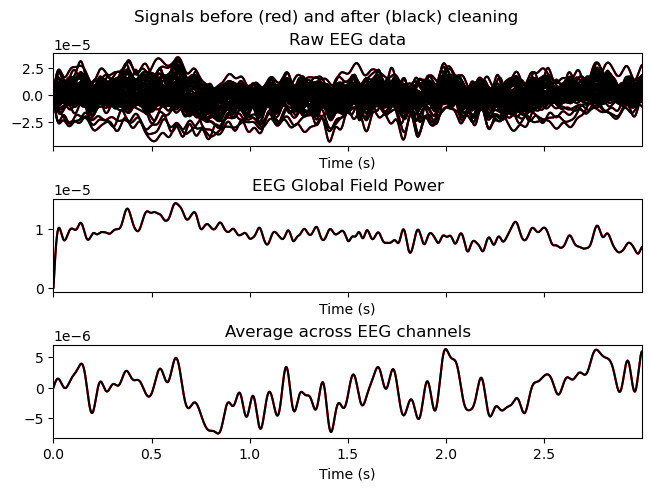

Applying ICA to Raw instance
    Transforming to ICA space (45 components)
    Zeroing out 0 ICA components
    Projecting back using 63 PCA components


<RawANT | Garrett_Burchfield_2025-06-09_13-21-30.cnt, 63 x 1782487 (1782.5 s), ~856.8 MiB, data loaded>

In [55]:
ica = ICA(n_components=45, max_iter="auto", random_state=97)
ica.fit(reconst_raw)

ecg_indices = []
ecg_i, ecg_scores = ica.find_bads_ecg(reconst_raw, ch_name='Oz',method="correlation", threshold="auto")
ecg_indices = ecg_indices + ecg_i
print('\n',ecg_indices,'\n','\n')

ica.exclude = ecg_indices
print(len(ica.exclude))
ica.plot_overlay(reconst_raw, exclude=ica.exclude, picks="eeg")

ica.apply(reconst_raw)

## Run Filter

In [56]:
raw_bandpass = reconst_raw.copy().filter(h_freq=15, l_freq=None,n_jobs=8)
raw_bandpass = raw_bandpass.filter(h_freq=None, l_freq=0.5,n_jobs=8)
fig = reconst_raw.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
fig = raw_bandpass.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 881 samples (0.881 s)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:   24.9s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:   29.9s finished


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done  63 out of  63 | elapsed:    6.6s finished


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\yu028288\AppData\Local\anaconda3\envs\MNE\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\yu028288\AppData\Local\anaconda3\envs\MNE\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [57]:
raw.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=1e-5)
reconst_raw.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=1e-5)
raw_bandpass.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=1e-5)

## Split Epochs

In [58]:
def split_train_triggers(train_sound_event):
    if train_sound_event.shape[0]!=420:
        raise ValueError("\nIncorrect training session trial number!!!\n")
    else:
        train_triggers = []
        small_block = [1,1,1,3,2,2,2]
        for i in range(60):
            train_triggers = train_triggers + small_block
        event_id = {'SWS_Pre': 5, 'SWS_Post': 6, 'NS': 7}
        train_triggers = np.array(train_triggers)+4
        train_triggers = np.vstack([train_sound_event[:,:2].T,train_triggers])
        return train_triggers.T,event_id
        
        

In [59]:
train_triggers,train_event_id = split_train_triggers(train_sound_event)

In [60]:
erp_baseline = (-0.2,0)

epochs_train = mne.Epochs(raw_bandpass, list(train_triggers),event_id = train_event_id, tmin=-0.2, tmax=1, baseline = erp_baseline, preload=False, detrend=if_detrend)
#epochs_train = epochs_train.apply_baseline()
epochs_pre = mne.Epochs(raw_bandpass, list(pre_event), tmin=-0.2, tmax=1, baseline = erp_baseline, preload=False, detrend=if_detrend)
#epochs_pre = epochs_pre.apply_baseline()
epochs_post = mne.Epochs(raw_bandpass, list(post_event), tmin=-0.2, tmax=1, baseline = erp_baseline, preload=False, detrend=if_detrend)
#epochs_post = epochs_post.apply_baseline()

epochs = mne.Epochs(raw_bandpass, list(np.vstack([pre_event,train_sound_event,post_event])), tmin=-0.2, tmax=0.8, baseline = erp_baseline, preload=False, detrend=if_detrend)
epochs = epochs.apply_baseline()

print(epochs.info.ch_names)

Not setting metadata
420 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
540 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Applying baseline correction (mode: mean)
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']


In [61]:
epochs_train.plot(n_epochs=20, events=train_sound_event,n_channels=63,scalings=2e-5)

Using data from preloaded Raw for 420 events and 1201 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 1201 original time points ...
Using data from preloaded Raw for 42 events and 1201 original time points ...


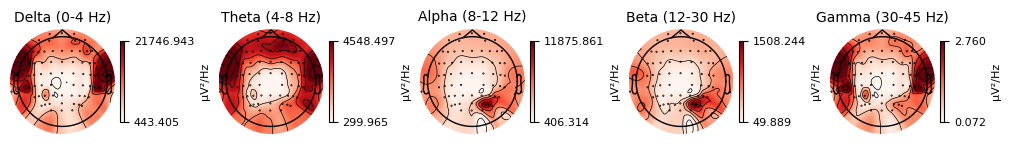

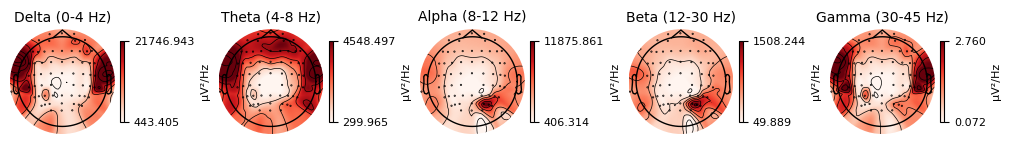

In [63]:
spectrum = epochs_train.compute_psd()
spectrum.plot_topomap()

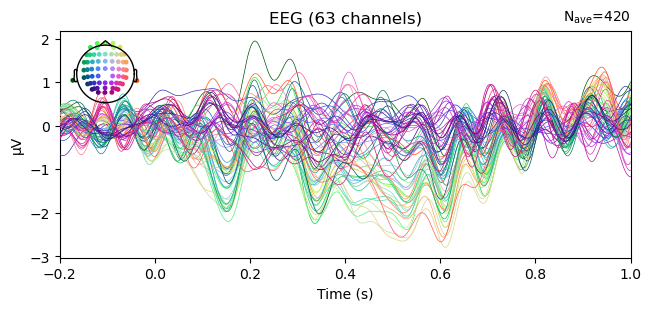

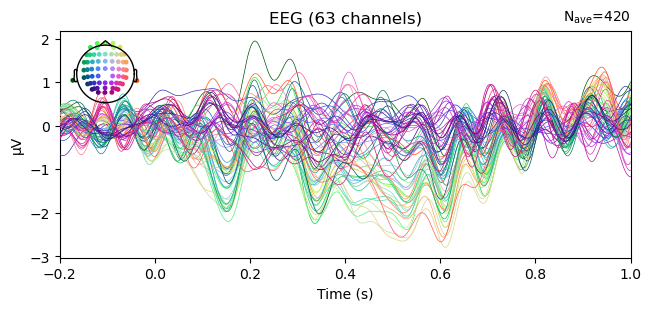

In [64]:
evoked = epochs_train.average()
evoked.plot(spatial_colors=True)

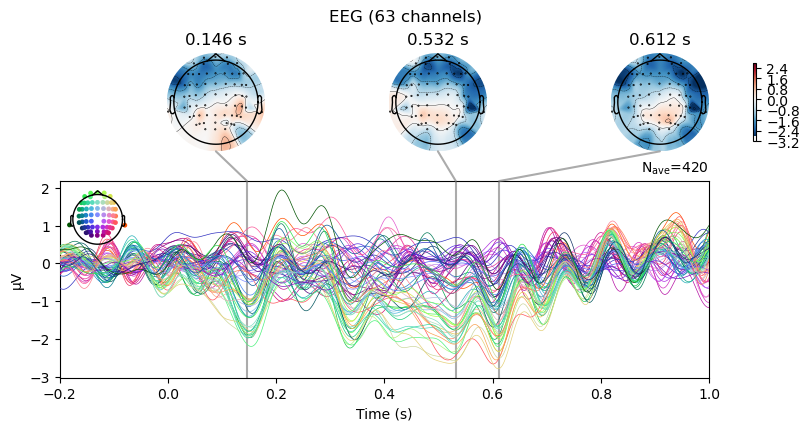

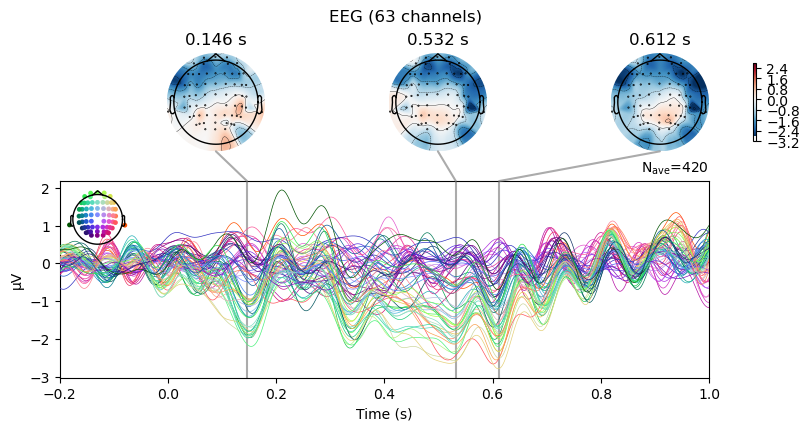

In [65]:
evoked.plot_joint(times='peaks')

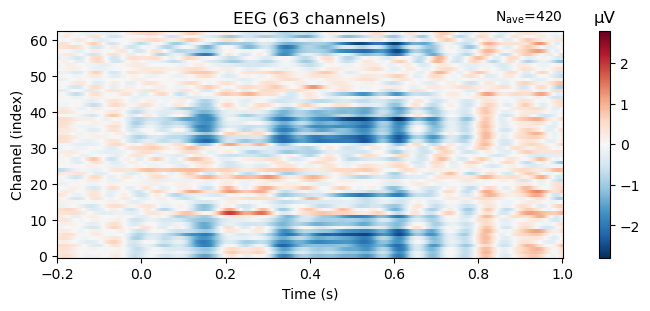

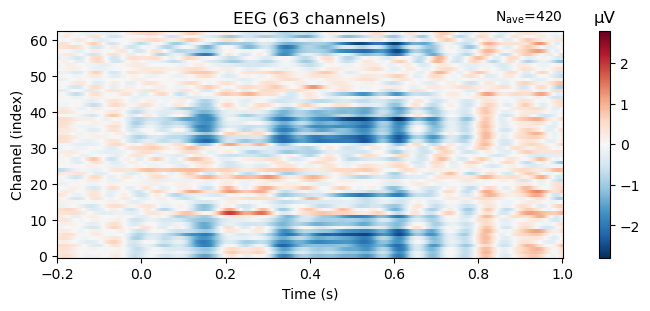

In [66]:
evoked.plot_image()

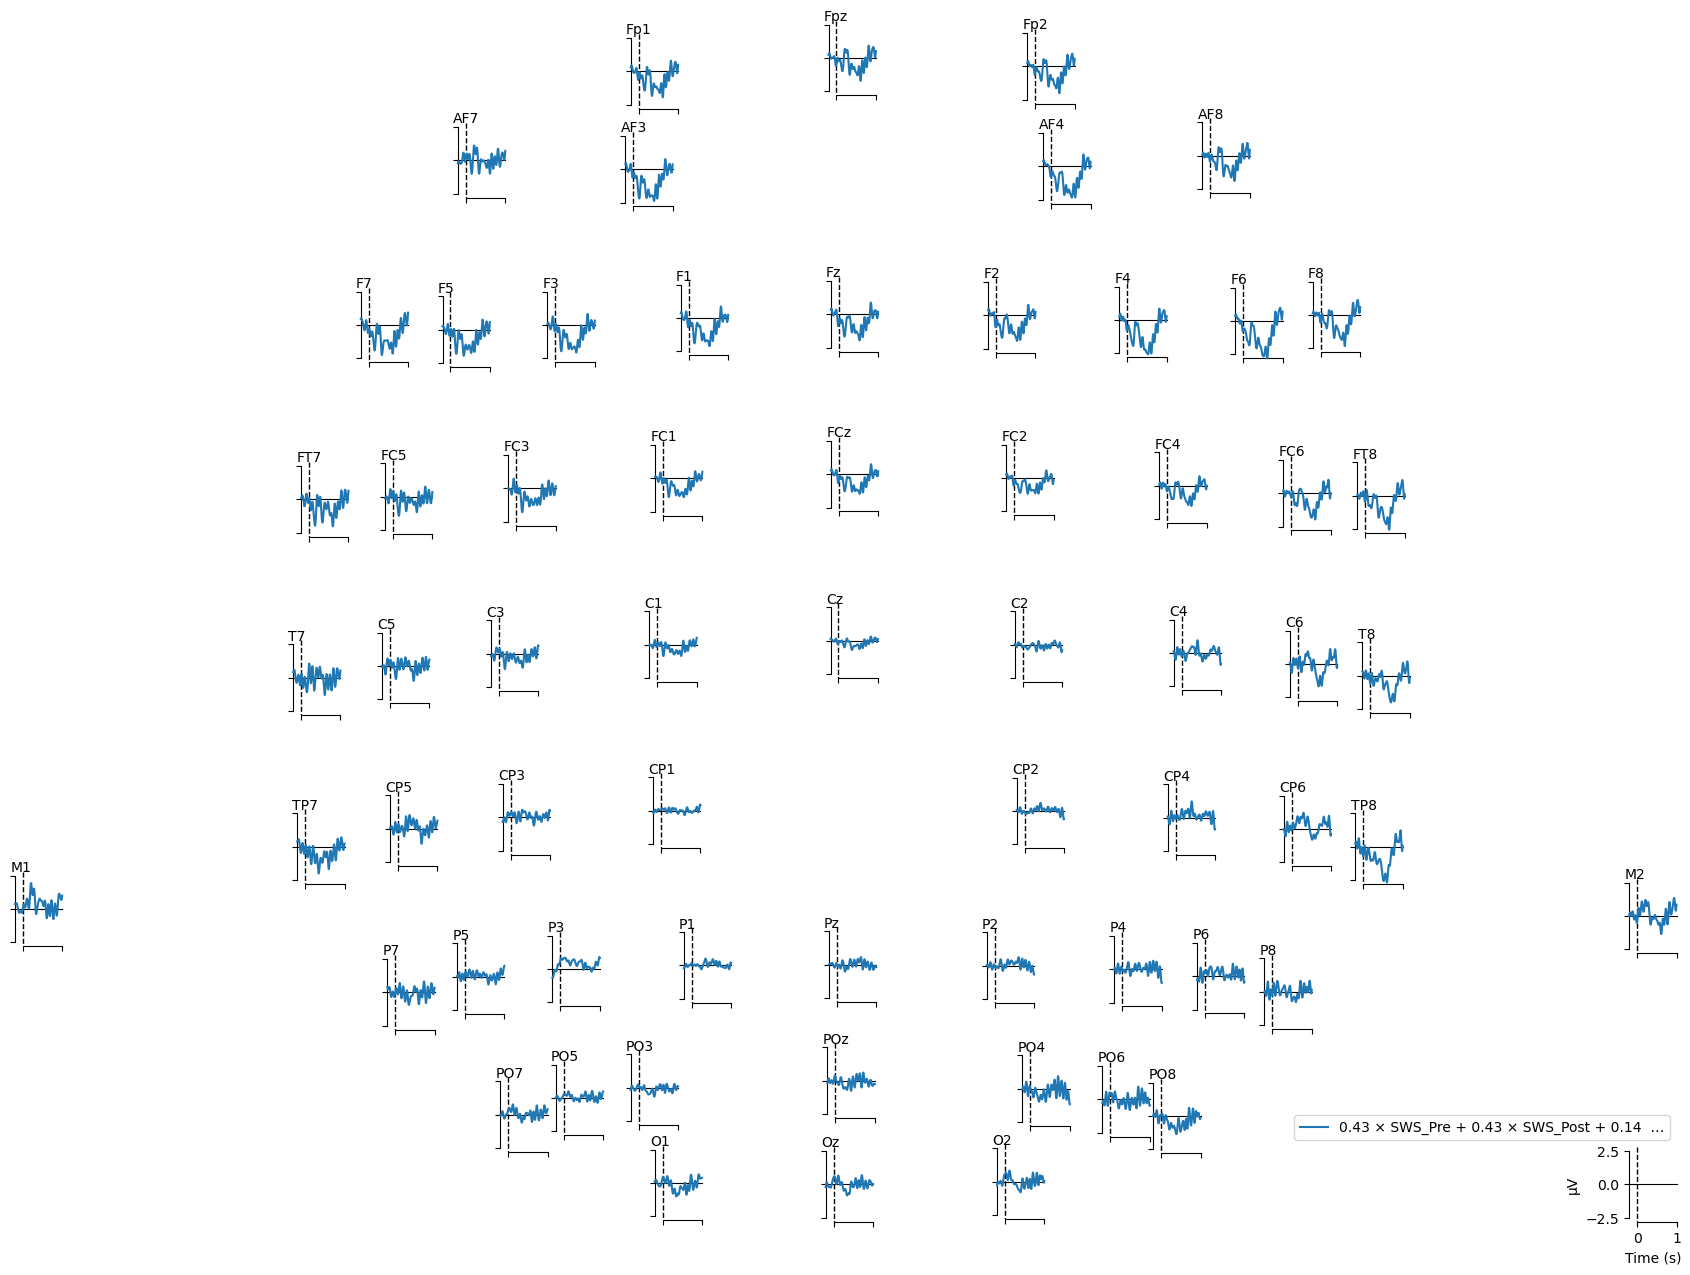

[<Figure size 1800x1400 with 64 Axes>]

In [67]:
mne.viz.plot_compare_evokeds(
    evoked,
    axes="topo",
)

C:\Users\yu028288\AppData\Local\anaconda3\envs\MNE\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


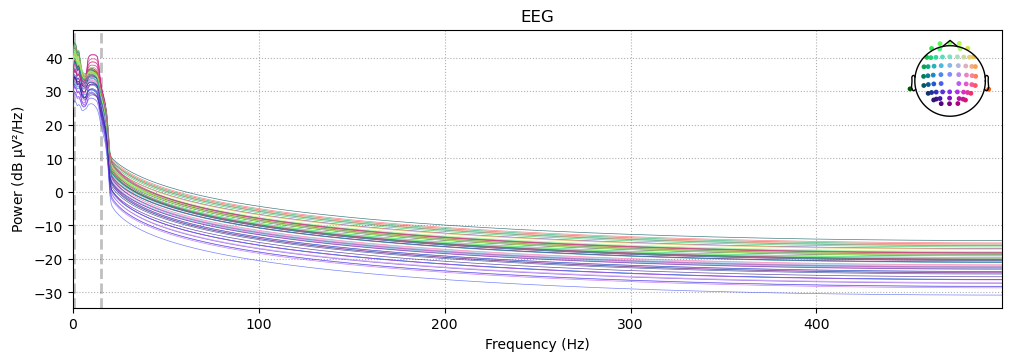

In [68]:
epochs_train.compute_psd().plot(picks="eeg", exclude="bads", amplitude=False)

## Export epochs

In [69]:
print(participant_index)
export_fname = raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-2_lowband_onsetshifting-epo.fif'
epochs_train.save(export_fname,overwrite=True)
export_fname = raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-1_lowband_onsetshifting-epo.fif'
epochs_pre.save(export_fname,overwrite=True)
export_fname = raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-3_lowband_onsetshifting-epo.fif'
epochs_post.save(export_fname,overwrite=True)

0


[WindowsPath('C:/Users/yu028288/OneDrive - University of Central Florida/Documents/Python Scripts/SWS_OneShotLearning_2025/Analysis/EEG_SWS/EEG/EEG_SWS/Sub-001_June-09/Sub-001_June-09_blk-3_lowband_onsetshifting-epo.fif')]

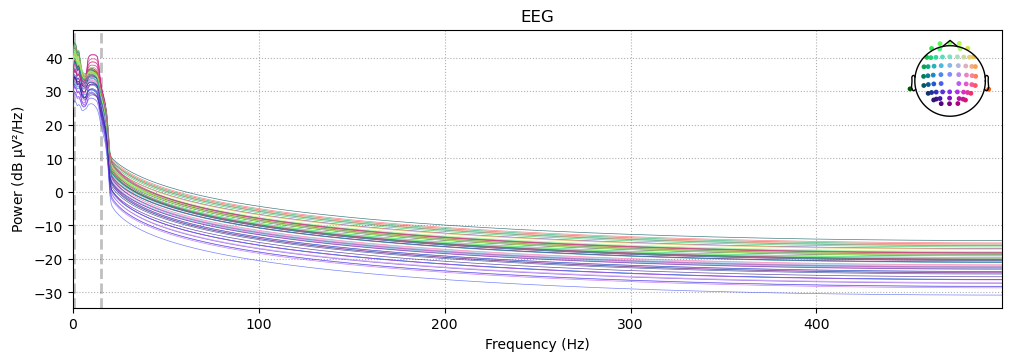

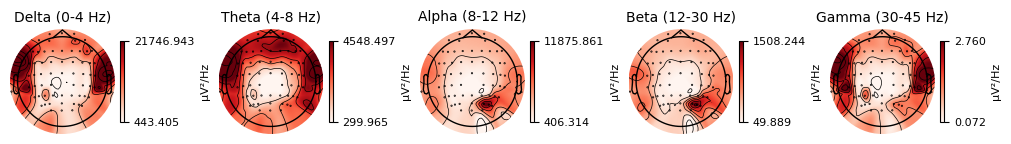

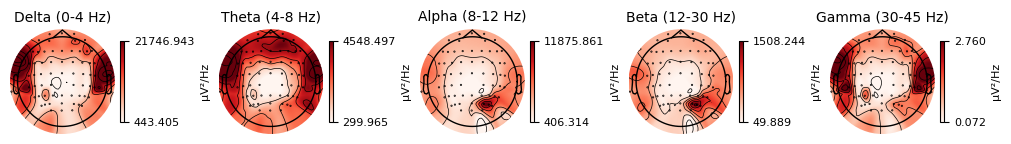

In [70]:
epochs_blk2 = mne.read_epochs(raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-2_lowband_onsetshifting-epo.fif', proj=True, preload=False)

spectrum = epochs_blk2.compute_psd()
spectrum.plot_topomap()

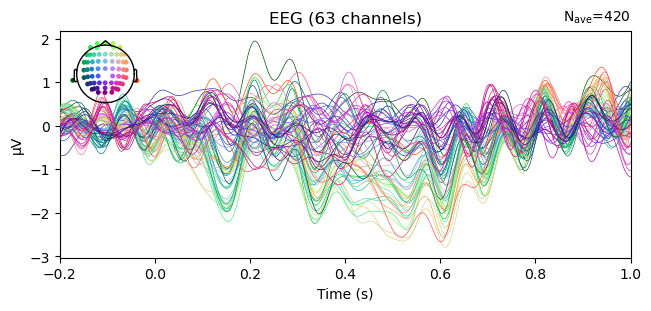

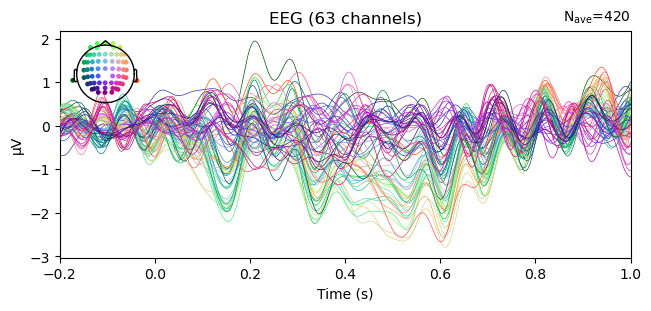

In [71]:
evoked = epochs_blk2.average()
evoked.plot(spatial_colors=True)

# High Band

### ICA

In [73]:
ica = ICA(n_components=45, max_iter="auto", random_state=97)
ica.fit(raw_high_eogremove)

ecg_indices = []
ecg_i, ecg_scores = ica.find_bads_ecg(raw_high_eogremove, ch_name='Oz',method="correlation", threshold="auto")
ecg_indices = ecg_indices + ecg_i
print('\n',ecg_indices,'\n','\n')
emg_indices = []


 [13] 
 



### ICA remove EMG

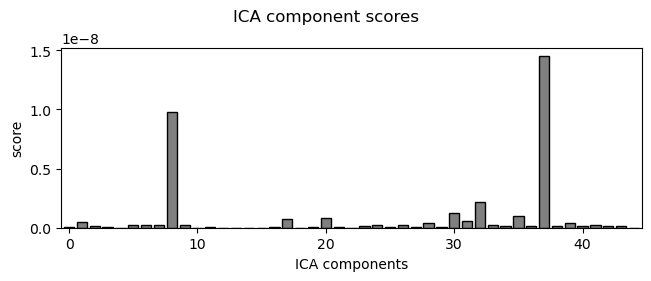

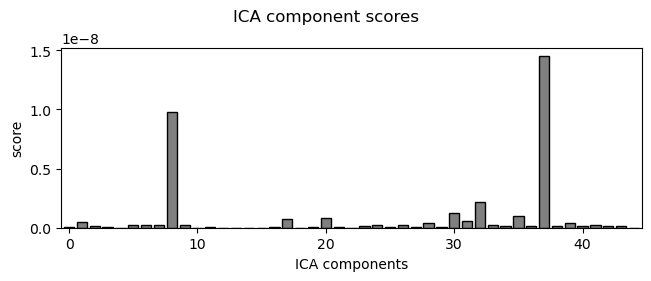

In [74]:
emg_indices, emg_scores = ica.find_bads_muscle(raw_eog_band,threshold=0.65)
ica.plot_scores(emg_scores, exclude=emg_indices)

1


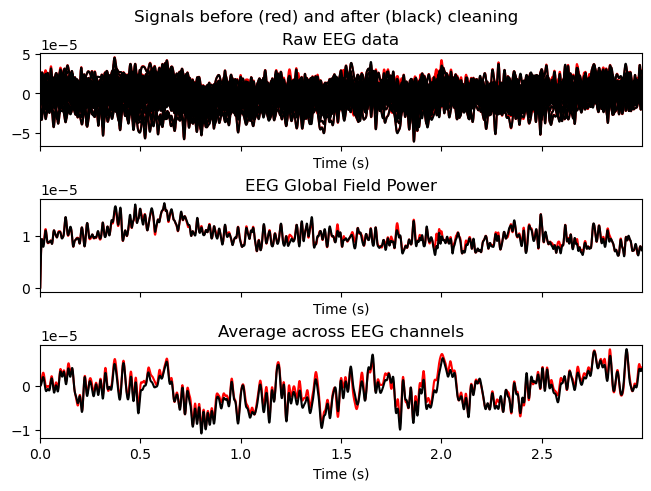

<RawANT | Garrett_Burchfield_2025-06-09_13-21-30.cnt, 63 x 1782487 (1782.5 s), ~856.8 MiB, data loaded>

In [75]:
ica.exclude = ecg_indices + emg_indices
print(len(ica.exclude))
ica.plot_overlay(raw_high_eogremove, exclude=ica.exclude, picks="eeg")

ica.apply(raw_high_eogremove)

## Run Filter

In [76]:
raw_bandpass = raw_high_eogremove.copy().filter(h_freq=45, l_freq=None,n_jobs=8)
raw_bandpass = raw_bandpass.filter(h_freq=None, l_freq=0.1,n_jobs=8)
fig = reconst_raw.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
fig = raw_bandpass.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

C:\Users\yu028288\AppData\Local\anaconda3\envs\MNE\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\yu028288\AppData\Local\anaconda3\envs\MNE\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [77]:
raw.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=1e-5)
reconst_raw.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=1e-5)
raw_bandpass.plot(n_channels=63, remove_dc=False,color='darkblue',scalings=1e-5)

## Split Epochs

In [78]:
def split_train_triggers(train_sound_event):
    if train_sound_event.shape[0]!=420:
        raise ValueError("\nIncorrect training session trial number!!!\n")
    else:
        train_triggers = []
        small_block = [1,1,1,3,2,2,2]
        for i in range(60):
            train_triggers = train_triggers + small_block
        event_id = {'SWS_Pre': 5, 'SWS_Post': 6, 'NS': 7}
        train_triggers = np.array(train_triggers)+4
        train_triggers = np.vstack([train_sound_event[:,:2].T,train_triggers])
        return train_triggers.T,event_id
        
        

In [79]:
train_triggers,train_event_id = split_train_triggers(train_sound_event)

In [80]:
erp_baseline = (-0.2,0)

epochs_train = mne.Epochs(raw_bandpass, list(train_triggers),event_id = train_event_id, tmin=-0.2, tmax=1, baseline = erp_baseline, preload=False, detrend=if_detrend)
#epochs_train = epochs_train.apply_baseline()
epochs_pre = mne.Epochs(raw_bandpass, list(pre_event), tmin=-0.2, tmax=1, baseline = erp_baseline, preload=False, detrend=if_detrend)
#epochs_pre = epochs_pre.apply_baseline()
epochs_post = mne.Epochs(raw_bandpass, list(post_event), tmin=-0.2, tmax=1, baseline = erp_baseline, preload=False, detrend=if_detrend)
#epochs_post = epochs_post.apply_baseline()

epochs = mne.Epochs(raw_bandpass, list(np.vstack([pre_event,train_sound_event,post_event])), tmin=-0.2, tmax=0.8, baseline = erp_baseline, preload=False, detrend=if_detrend)
epochs = epochs.apply_baseline()

print(epochs.info.ch_names)

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']


In [81]:
epochs_train.plot(n_epochs=20, events=train_sound_event,n_channels=63,scalings=2e-5)

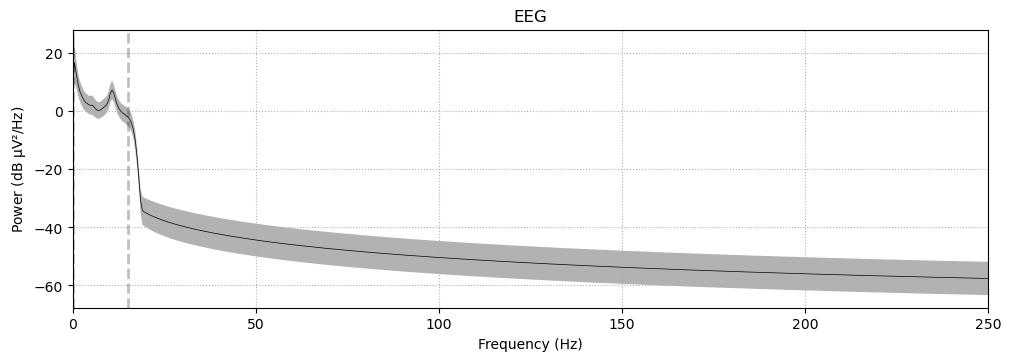

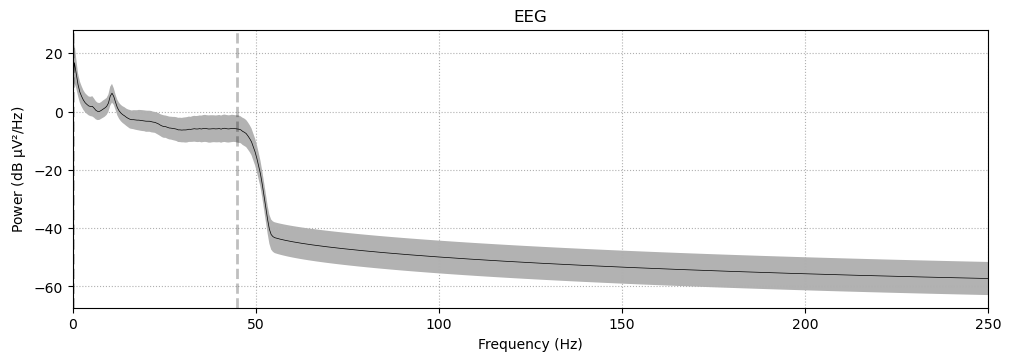

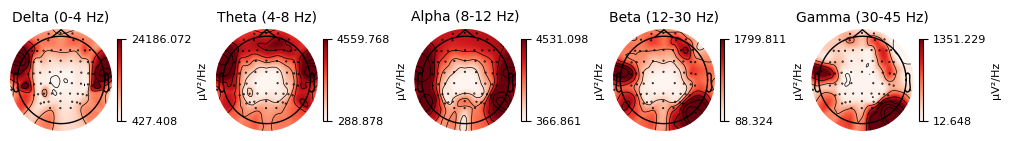

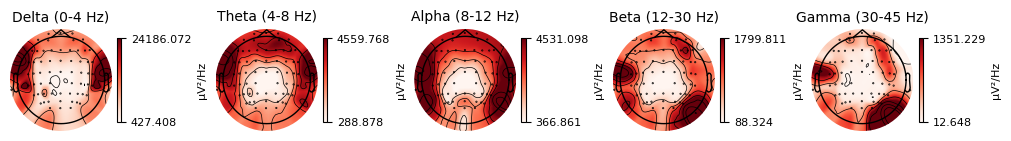

In [82]:
spectrum = epochs_train.compute_psd()
spectrum.plot_topomap()

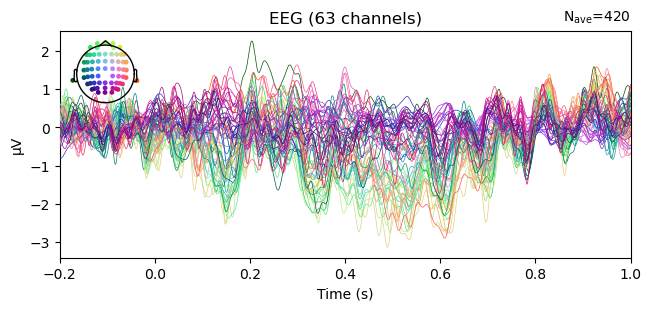

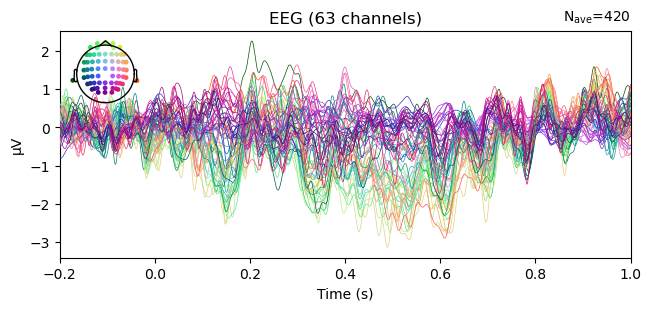

In [83]:
evoked = epochs_train.average()
evoked.plot(spatial_colors=True)

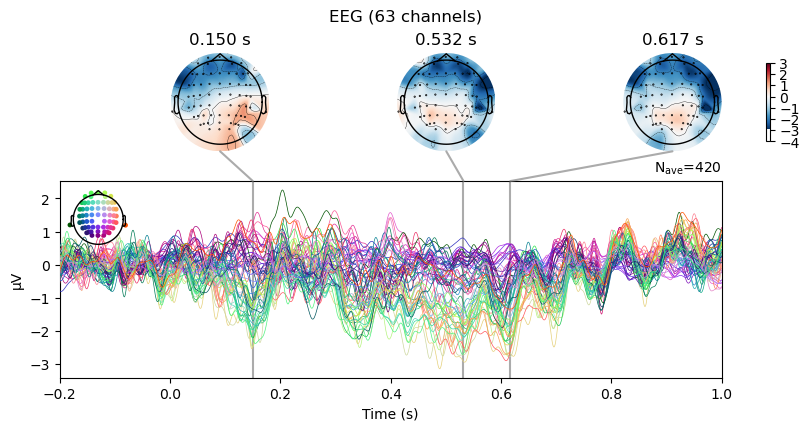

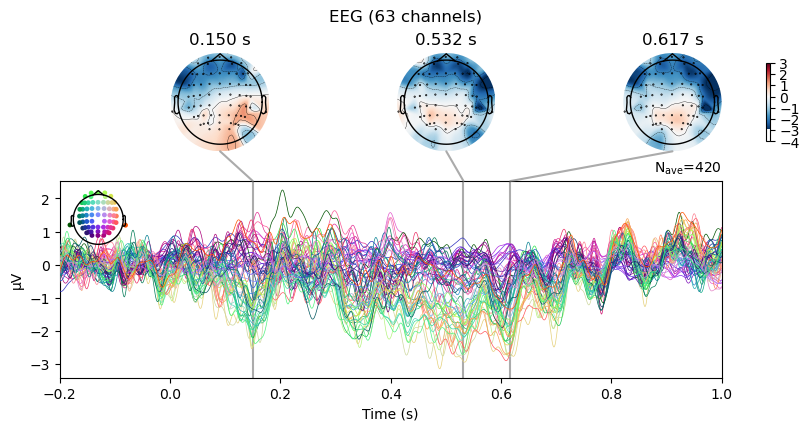

In [84]:
evoked.plot_joint(times='peaks')

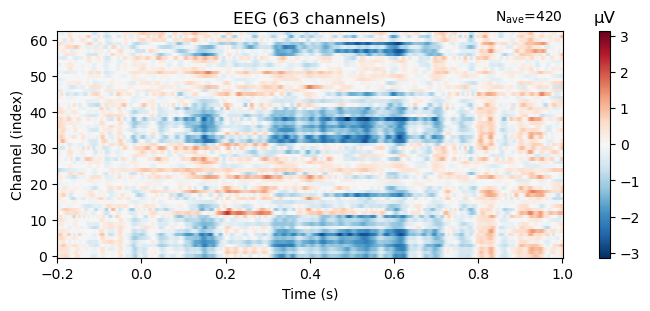

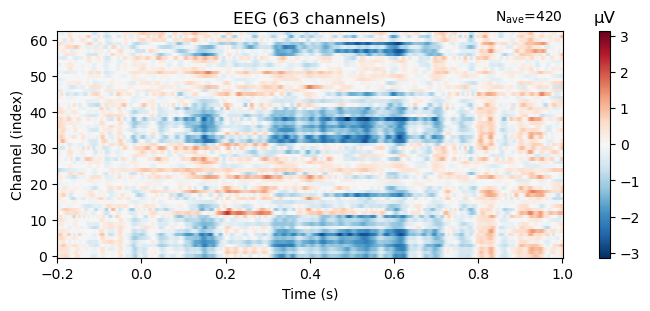

In [85]:
evoked.plot_image()

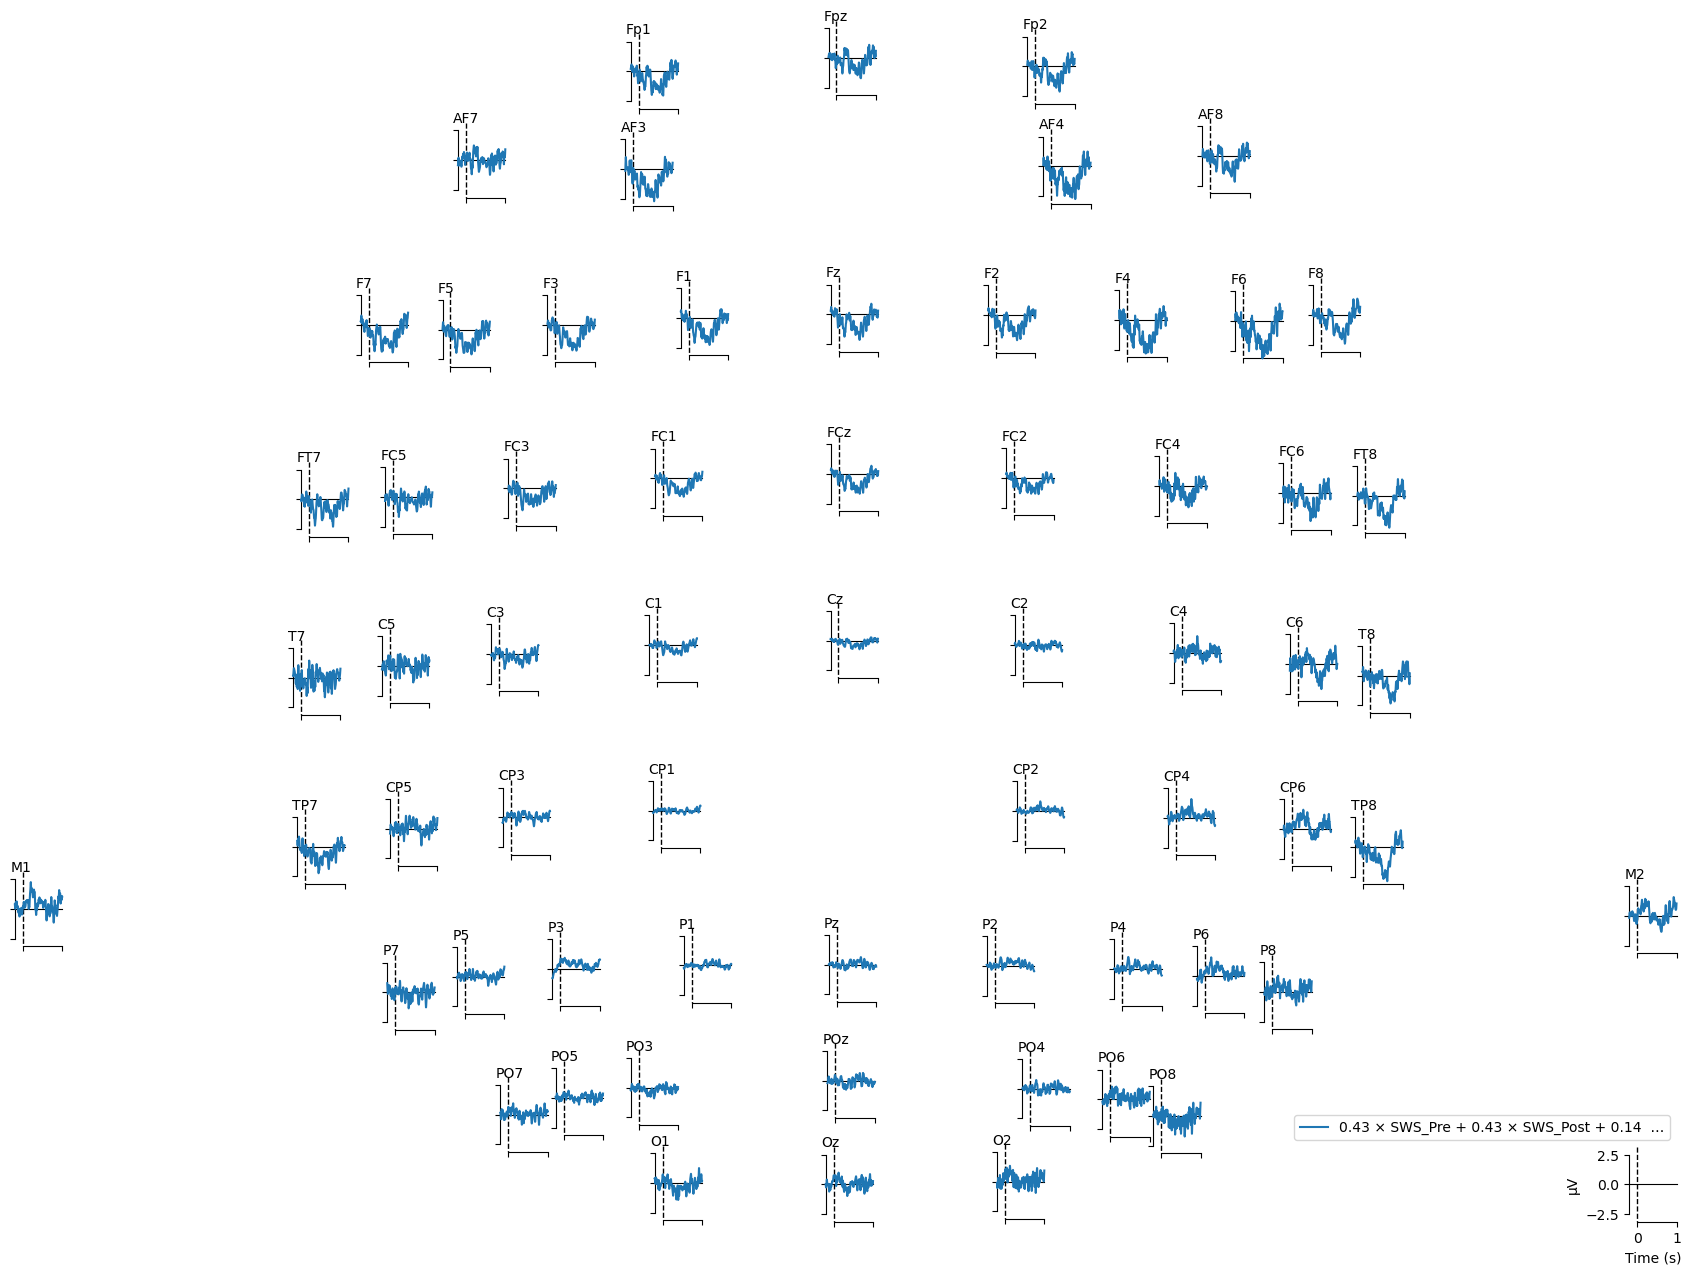

[<Figure size 1800x1400 with 64 Axes>]

In [86]:
mne.viz.plot_compare_evokeds(
    evoked,
    axes="topo",
)

C:\Users\yu028288\AppData\Local\anaconda3\envs\MNE\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


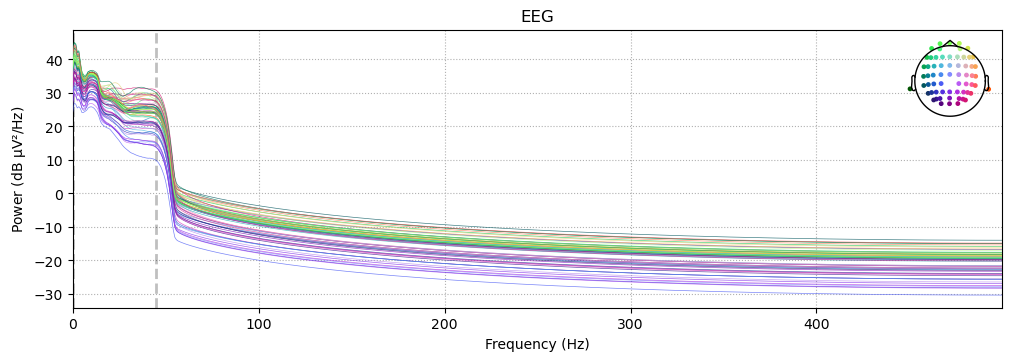

In [87]:
epochs_train.compute_psd().plot(picks="eeg", exclude="bads", amplitude=False)

## Export epochs

In [88]:
print(participant_index)
export_fname = raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-2_highband_onsetshifting-epo.fif'
epochs_train.save(export_fname,overwrite=True)
export_fname = raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-1_highband_onsetshifting-epo.fif'
epochs_pre.save(export_fname,overwrite=True)
export_fname = raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-3_highband_onsetshifting-epo.fif'
epochs_post.save(export_fname,overwrite=True)

0


[WindowsPath('C:/Users/yu028288/OneDrive - University of Central Florida/Documents/Python Scripts/SWS_OneShotLearning_2025/Analysis/EEG_SWS/EEG/EEG_SWS/Sub-001_June-09/Sub-001_June-09_blk-3_highband_onsetshifting-epo.fif')]

In [ ]:
epochs_blk2 = mne.read_epochs(raw_eeg_path+participant_list[participant_index]+'/' + participant_list[participant_index] + '_blk-2_highband_onsetshifting-epo.fif', proj=True, preload=False)

spectrum = epochs_blk2.compute_psd()
spectrum.plot_topomap()

# Test raw erp

In [ ]:
raw_event_f = raw_event.copy().filter(h_freq=25, l_freq=None,n_jobs=8)
raw_event_f = raw_event_f.filter(h_freq=None, l_freq=0.1,n_jobs=8)

In [ ]:
epochs_train = mne.Epochs(raw_event_f, list(train_triggers),event_id = train_event_id, tmin=-0.2, tmax=0.8, baseline = (-0.2,0),preload=False,detrend=if_detrend)
#epochs_train = epochs_train.apply_baseline()
evoked = epochs_train.average()

In [ ]:
print(f"Epochs baseline: {epochs_train.baseline}")
print(f"Evoked baseline: {evoked.baseline}")

In [ ]:
evoked.plot()

# Test block 2

In [81]:
train_pre_e = epochs_train[epochs_train.events[:, 2] == epochs_train.event_id["SWS_Pre"]]
train_pre_data = train_pre_e.get_data(copy=True)
train_post_e = epochs_train[epochs_train.events[:, 2] == epochs_train.event_id["SWS_Post"]]
train_post_data = train_post_e.get_data(copy=True)

In [82]:
ch_names = epochs.info.ch_names.copy()
print(ch_names)
#tar_ch = ['FT7','T7','TP7','FC5','C5','CP5','FC3','C3','CP3']
tar_ch = ['FT8','T8','TP8','FC6','C6','CP6','FC4','C4','CP4']
ch_i = [index for index, element in enumerate(ch_names) if element in tar_ch]
print(ch_i)

['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
[11, 16, 17, 22, 41, 45, 47, 57, 59]


In [83]:
plt.plot(np.mean(np.mean(train_pre_data[:,ch_i],axis=0),axis=0),color='r')
plt.plot(np.mean(np.mean(train_post_data[:,ch_i],axis=0),axis=0),color='b')

In [84]:
print(train_pre_e.info)

<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 63 EEG, 1 EOG
 custom_ref_applied: False
 device_info: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 25.0 Hz
 meas_date: 2025-06-17 16:03:27 UTC
 nchan: 64
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: , first_name: Eseroghene Awusa, sex: 0, birthday: 2003-12-28>
>


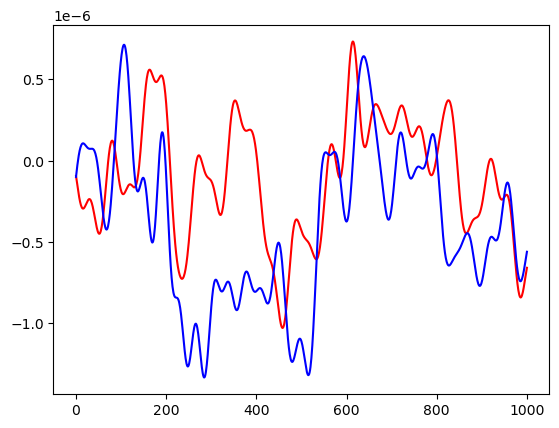

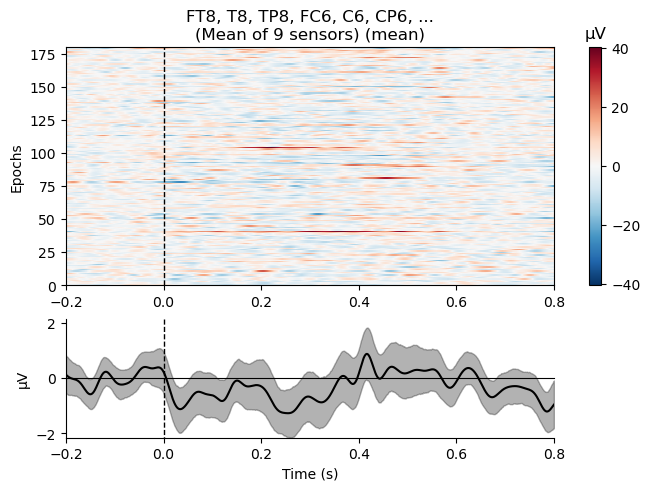

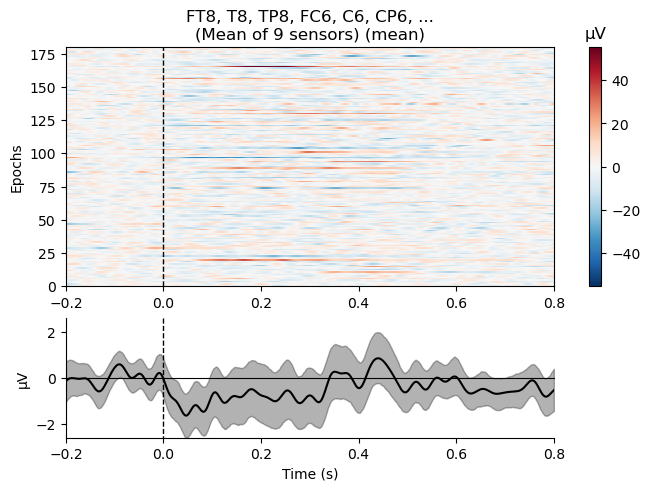

[<Figure size 640x480 with 3 Axes>]

In [85]:
train_pre_e.plot_image(picks=tar_ch, combine="mean")
train_post_e.plot_image(picks=tar_ch, combine="mean")

# Baseline Regressor

In [172]:
ch = 'CP1'
baseline = (-0.2, 0)
baseline_predictor = (
    epochs.copy()
    .crop(*baseline)
    .pick([ch])
    .get_data(copy=False)  # convert to NumPy array
    .mean(axis=-1)  # average across timepoints
    .squeeze()  # only 1 channel, so remove singleton dimension
)
baseline_predictor *= 1e6  # convert V → μV
design_matrix = np.vstack(
    [
        epochs_train,
        baseline_predictor,
        baseline_predictor * epochs_train,
    ]
).T
reg_model = mne.stats.linear_regression(
    epochs, design_matrix, names=["epochs_train", "baseline", "baseline:epochs_train"]
)
effect_of_baseline = reg_model["baseline"].beta
effect_of_baseline.plot(
    picks=ch,
    hline=[1.0],
    units=dict(eeg=r"$\beta$ value"),
    titles=dict(eeg=ch),
    selectable=False,
)
reg_train = reg_model["epochs_train"].beta
kwargs = dict(picks=ch, show_sensors=False, truncate_yaxis=False)
mne.viz.plot_compare_evokeds(
    dict(auditory=epochs_train), title="Traditional", **kwargs
)
mne.viz.plot_compare_evokeds(
    dict(auditory=reg_train), title="Regression-based", **kwargs
)

ValueError: operands could not be broadcast together with shapes (540,63) (540,63,1001) 

In [ ]:
reg_train = reg_model["epochs_train"].beta
kwargs = dict(picks=ch, show_sensors=False, truncate_yaxis=False)
mne.viz.plot_compare_evokeds(
    dict(auditory=epochs_train), title="Traditional", **kwargs
)
mne.viz.plot_compare_evokeds(
    dict(auditory=reg_train), title="Regression-based", **kwargs
)